## 3. Modul

### Felügyelt gépi tanulás - Supervised Machine Learning

- Bináris osztályozási feladat (1 - Ady Endre versei, 0 - más szerzők versei)
- Modellek építése, validálása, tesztelése

In [1]:
%%capture
%pip install --upgrade pip
!pip3 install upgrade-pip
%pip install matplotlib
%pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import logging
import inspect
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC, SVC
from pathlib import Path

## Függvények

Tanító (train) és teszt (test) adathalmazok, osztálycímkék létrehozása

In [3]:
def train_test_function(csv_path):

    try:

        df_data = pd.read_csv(csv_path)

        X = df_data.iloc[:, :-1]
        y = df_data['class_label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        return df_data, X_train, X_test, y_train, y_test
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a tanuló és teszt adatbázis létrehozásakor ({def_name}):', e)
        logging.info(f'Hiba történt a tanuló és teszt adatbázis létrehozásakor ({def_name})')

Adatok átalakítása (transzformálás, skálázás)

In [4]:
def transformer_scaler_function(scaler, df):

    try:

        df_tr_sc = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

        return df_tr_sc
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt az adatátalakítása során ({def_name}):', e)
        logging.info(f'Hiba történt az adatátalakítása során ({def_name})')

Adatmegjelenítés hisztogramon

In [5]:
def histogram(df, piece):

    try:

        df.iloc[:, :piece].hist(color = 'darkcyan')
        plt.subplots_adjust(hspace = 0.5)
        plt.show()

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a histogram létrehozásakor ({def_name}):', e)
        logging.info(f'Hiba történt a histogram létrehozásakor ({def_name})')

K-szoros keresztvalidálás

In [6]:
def cross_validate_binary_classifiers(clf, X_train, y_train):

    try:

        kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        scores = cross_validate(clf, X_train, y_train, scoring = scoring, cv = kfold, return_train_score = True)

        for metric in scoring:
            print(metric + ":", ", ".join([str(round(score, 3)) for score in scores['test_' + metric]]))
            print("Átlagos:", round(np.mean(scores['test_' + metric]), 4))
            print("Szórás:", round(np.std(scores['test_' + metric]), 4))
            
        print(clf, "paraméterek:",  clf.get_params(deep = True))

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a keresztvalidáció során ({def_name}):', e)
        logging.info(f'Hiba történt a keresztvalidáció során ({def_name})')

Rácskeresés keresztvalidációval (paraméterek ompimalizálása)

In [7]:
def grid_search_with_cross_validate(clf, param_grid, X_train, y_train):

    try:

        kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)
        grid_search = GridSearchCV(clf, param_grid, cv = kfold)
        grid_search.fit(X_train, y_train)
        clf_best = grid_search.best_estimator_

        print(clf_best.get_params())

        return clf_best
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a rácskeresés (keresztvalidált) közben ({def_name}):', e)
        logging.info(f'Hiba történt a rácskeresés (keresztvalidált) közben ({def_name})')

Kiválasztott jellemzők megjelenítése (maszk) diagramon

In [8]:
def features_mask_function(indices, title):

    try:

        plt.matshow(indices.reshape(1, -1), cmap = 'gray_r')
        plt.title(title)
        plt.show()

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a maszk diagramjának megjelenítésekor ({def_name}):', e)
        logging.info(f'Hiba történt a maszk diagramjának megjelenítésekor ({def_name})')

Modellek pontossága a kiválasztott jellezők függvényében (diagram)

In [9]:
def accuracy_by_feature_num(k_values, clf, X_train, y_train):

    try:

        score_means = []
        score_stds = []    

        for k in k_values:
            clf.set_params(select__k = k)
            this_scores = cross_val_score(clf, X_train, y_train)
            score_means.append(this_scores.mean())
            score_stds.append(this_scores.std())

        tick_and_interval = math.ceil(max(k_values) / 10) * 10

        plt.errorbar(k_values, score_means, np.array(score_stds), color = 'darkcyan')
        plt.title("Keresztellenőrzési pontszámok a kiválasztott jellemzők számának függvényében")
        plt.xticks(np.linspace(0, tick_and_interval, int(tick_and_interval / 10) + 1, endpoint = True))
        plt.xlabel("Jellemzők száma")
        plt.ylabel("Pontosság (accuracy)")
        plt.axis("tight")
        plt.show()

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a pontosság (diagram) megjelenítésekor ({def_name}):', e)
        logging.info(f'Hiba történt a pontosság (diagram) megjelenítésekor ({def_name})')

Mérőszámok a modellek értékeléséhez (report)

In [10]:
def get_clf_report(y_test, y_pred):

    print(classification_report(y_test, y_pred, digits = 4, zero_division = 0))
    rounded_cm = [[round(entry, 3) for entry in row] for row in confusion_matrix(y_test, y_pred, normalize = 'all')]
    for row in rounded_cm:
        print(row)

Hibakezelés függvényhíváskor

In [11]:
def error_handler(function):
    
    try:
        result = function()
        return result
    except Exception as e:
        calling_function_name = function.__name__
        print(f'Probléma van a függvény hívásnál ({calling_function_name}):', e)
        logging.info(f'Probléma van a függvény hívásnál ({calling_function_name})')

Logfájl létrehozása

In [12]:
logging.basicConfig(filename = 'infoEvent.log', level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s', encoding = 'utf-8')

### Adatok beolvasása, tanító és teszt adathalmazok létrehozása

Objektumok típusának és méretének lekérdezése

Az összes verset tartalmazó adathalmaz

In [13]:
current_dir = Path.cwd()

parent_dir = current_dir.parent

data_path = parent_dir / "Modul 2" / "data.csv"

df_data, X_train, X_test, y_train, y_test = error_handler(lambda: train_test_function(data_path))
# df_data.info()
# df_data.head()

In [14]:
# print('X_train:', X_train.shape)
# print(X_test.shape)
# print(len(y_train))
# print(len(y_test))

A kiegyensúlyozott osztályokkal rendelkező adathalmaz

In [15]:
data_balanced_path = parent_dir / "Modul 2" / "data_balanced.csv"

df_data_balanced, X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = error_handler(lambda: train_test_function(data_balanced_path))
# df_data_balanced.info()
# df_data_balanced.head()

In [16]:
# print('X_train_balanced:', X_train_balanced.shape)
# print(X_test_balanced.shape)
# print(len(y_train_balanced))
# print(len(y_test_balanced))

A 2. modul statisztikai eszközeivel és a szakirodalom alapján létrehozott adathalmaz (16 jellemző)

In [17]:
data_top_features_path = parent_dir / "Modul 2" / "data_top_features.csv"

df_data_top_features, X_train_top, X_test_top, y_train_top, y_test_top = error_handler(lambda: train_test_function(data_top_features_path))
# df_data_top_features.info()
# df_data_top_features.head()

In [18]:
# print('X_train_top:', X_train_top.shape)
# print(X_test_top.shape)
# print(len(y_train_top))
# print(len(y_test_top))

### Dimenziócsökkentés jellemző kiválasztással - elemzés

Statisztikai alapú jellemző kiválasztás (SelectKBest):
- Adott számú jellemző fontossági sorrendje
- Szelektált adathalmaz létrehozása
- A kiválasztott jellemzők vizualizálása

In [19]:
k = 16
select_SKB = SelectKBest(f_classif, k = k)
X_train_selected = select_SKB.fit_transform(X_train, y_train)

selected_feature_indexes = select_SKB.get_support()
selected_feature_names = X_train.columns[selected_feature_indexes]

feature_scores = select_SKB.scores_[selected_feature_indexes]
sorted_selected_features = sorted(zip(selected_feature_names, feature_scores), key = lambda x: x[True], reverse = True)
print("Kiválasztott jellemzők (fontossági sorrend):")
for feature, score in sorted_selected_features:
    print(f'Feature: {feature}, Score: {round(score, 3)}')

Kiválasztott jellemzők (fontossági sorrend):
Feature: q1_nWord_l, Score: 163.329
Feature: mean_nWord_l, Score: 152.171
Feature: med_nWord_l, Score: 140.036
Feature: q1_nShortS_l, Score: 136.651
Feature: q1_nLongS_l, Score: 129.344
Feature: max_nWord_l, Score: 127.865
Feature: q3_nWord_l, Score: 118.071
Feature: mean_nSyll_l, Score: 112.469
Feature: mean_nShortS_l, Score: 105.621
Feature: mean_nLongS_l, Score: 104.044
Feature: rstd_nSyll_lg, Score: 102.914
Feature: min_nShortS_l, Score: 102.904
Feature: med_nLongS_l, Score: 99.255
Feature: med_nShortS_l, Score: 99.078
Feature: med_nSyll_l, Score: 98.846
Feature: q3_nSyll_l, Score: 95.035


In [20]:
df_X_train_selected = pd.DataFrame(X_train_selected, columns = selected_feature_names)
# df_X_train_selected.head()

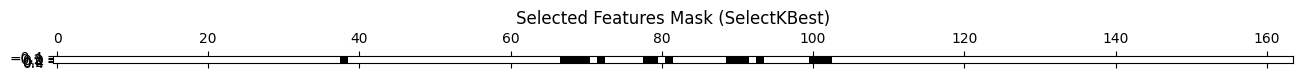

In [21]:
error_handler(lambda: features_mask_function(selected_feature_indexes, 'Selected Features Mask (SelectKBest)'))

Modell alapú jellemző kiválasztás (SelectFromModel - RandomForestClassifier)

- Jellemzők fontossági sorrendje (medián - 50%)
- Szelektált adathalmaz létrehozása
- A kiválasztott jellemzők vizualizálása

In [22]:
select_RFC = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42), threshold = f'{2.0} * median')
X_train_selected_RFC = select_RFC.fit_transform(X_train, y_train)

selected_feature_indexes_RFC = select_RFC.get_support()
selected_feature_names_RFC = X_train.columns[selected_feature_indexes_RFC]

feature_importances_RFC = select_RFC.estimator_.feature_importances_
sorted_selected_features = sorted(zip(selected_feature_names_RFC, feature_importances_RFC[selected_feature_indexes_RFC]), key = lambda x: x[True], reverse = True)
print("Kiválasztott jellemzők (fontossági sorrend):")
for feature_name, importance in sorted_selected_features:
    print(f'Feature: {feature_name}, Importance: {round(importance, 3)}')

Kiválasztott jellemzők (fontossági sorrend):
Feature: nWord_title, Importance: 0.073
Feature: mean_nSyll_l, Importance: 0.022
Feature: nRhymepair, Importance: 0.02
Feature: mean_nWord_l, Importance: 0.018
Feature: MADmean_nSyll_lg, Importance: 0.017
Feature: DET, Importance: 0.016
Feature: max_nSyll_l, Importance: 0.016
Feature: range_nSyll_lg, Importance: 0.015
Feature: NOUN, Importance: 0.014
Feature: max_nSyll_lg, Importance: 0.013
Feature: mean_lenWord, Importance: 0.013
Feature: q3_nSyll_l, Importance: 0.012
Feature: nStanza, Importance: 0.011
Feature: nWord, Importance: 0.011
Feature: q1_nSyll_l, Importance: 0.011
Feature: rate_PROPN_NOUN, Importance: 0.011
Feature: mean_nShortS_l, Importance: 0.011


In [23]:
X_train_selected_df_RFC = pd.DataFrame(X_train_selected_RFC, columns = selected_feature_names_RFC)
# X_train_selected_df_RFC.head()

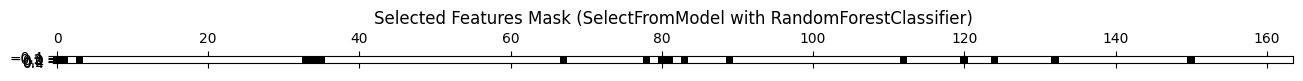

In [24]:
error_handler(lambda: features_mask_function(selected_feature_indexes_RFC, 'Selected Features Mask (SelectFromModel with RandomForestClassifier)'))

### Az adattranszformáció és az adatskálázás hatásának elemzése

Nyers adatok ábrázolása

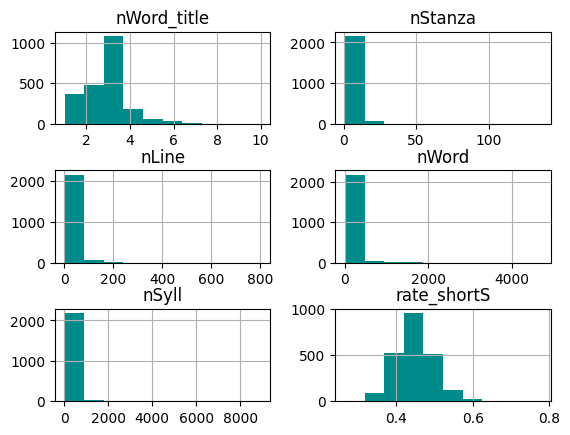

In [25]:
error_handler(lambda: histogram(X_train, 6))

Adattranszformálás (PowerTransformer)

- Eredeti és transzformált adatok összehasonlítása
- Vizualizálás

In [26]:
transformer = PowerTransformer(method = 'yeo-johnson', standardize = True)
powerTransformed_X_train = error_handler(lambda: transformer_scaler_function(transformer, X_train))
# powerTransformed_X_train.head()

In [27]:
item_number = 10
print("Illesztett jellemzők száma:", transformer.n_features_in_)  # Illesztett jellemzők számának megjelenítése
print("Lambda paraméterek:", [round(x, 3) for x in transformer.lambdas_[:item_number]])  # Lambda paraméterek megjelenítése
print("Átlagok transzformáció után:", [round(x, 3) for x in powerTransformed_X_train.mean().tolist()[:item_number]])
print("Átlaga transzformáció előtt:", [round(x, 3) for x in X_train.mean().tolist()[:item_number]])
print("Szórások a transzformáció után:", [round(x, 3) for x in powerTransformed_X_train.std().tolist()[:item_number]])
print("Szórások a transzformáció előtt:", [round(x, 3) for x in X_train.std().tolist()[:item_number]])

Illesztett jellemzők száma: 164
Lambda paraméterek: [0.316, -0.167, -0.138, -0.117, -0.11, -2.182, -0.951, -0.878, -0.782, -0.908]
Átlagok transzformáció után: [-0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0]
Átlaga transzformáció előtt: [2.693, 5.332, 29.714, 143.71, 277.419, 0.449, 8.041, 7.954, 7.557, 8.444]
Szórások a transzformáció után: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Szórások a transzformáció előtt: [1.148, 6.044, 33.239, 185.249, 359.542, 0.05, 12.393, 12.386, 12.008, 13.015]


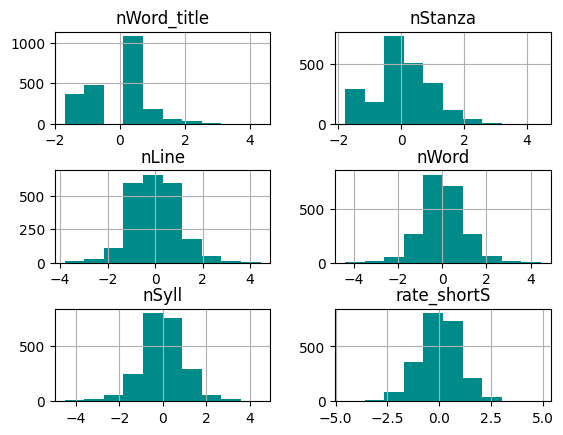

In [28]:
error_handler(lambda: histogram(powerTransformed_X_train, 6))

#### Adatskálázás
- Eredeti és transzformált adatok összehasonlítása
- Vizualizálás

Szabványosítás (StandardScaler)

In [29]:
scaler_standard = StandardScaler()
standardScaled_X_train = error_handler(lambda: transformer_scaler_function(scaler_standard, X_train))
# standardScaled_X_train.head()

In [30]:
print("Illesztett jellemzők száma:", scaler_standard.n_features_in_)  # Illesztett jellemzők számának megjelenítése
print("Relatív skálázási értékek:", [round(x, 3) for x in scaler_standard.scale_[:item_number]])  # Átskálázási tényezők megjelenítése
print("Átlagok a standardizálás után:", [round(x, 3) for x in standardScaled_X_train.mean().tolist()[:item_number]])
print("Átlagok a standardizálás előtt:", [round(x, 3) for x in scaler_standard.mean_[:item_number]])
print("Szórások a standardizálás után:", [round(x, 3) for x in standardScaled_X_train.std().tolist()[:item_number]])
print("Szórások a standardizálás előtt:", [round(x, 3) for x in X_train.std().tolist()[:item_number]])

Illesztett jellemzők száma: 164
Relatív skálázási értékek: [1.148, 6.042, 33.231, 185.208, 359.461, 0.05, 12.39, 12.384, 12.005, 13.012]
Átlagok a standardizálás után: [-0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
Átlagok a standardizálás előtt: [2.693, 5.332, 29.714, 143.71, 277.419, 0.449, 8.041, 7.954, 7.557, 8.444]
Szórások a standardizálás után: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Szórások a standardizálás előtt: [1.148, 6.044, 33.239, 185.249, 359.542, 0.05, 12.393, 12.386, 12.008, 13.015]


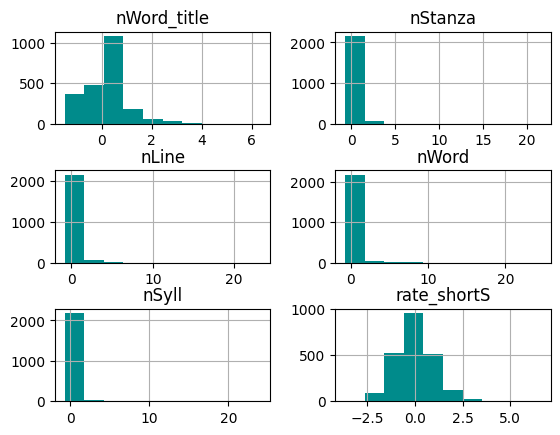

In [31]:
error_handler(lambda: histogram(standardScaled_X_train, 6))

Robosztus skálázás (RobustScaler)

In [32]:
lower_percentile = 0.25
upper_percentile = 0.75
scaler_robust = RobustScaler(with_scaling = True, quantile_range = (lower_percentile, upper_percentile))
robustScaled_X_train = error_handler(lambda: transformer_scaler_function(scaler_robust, X_train))
# robustScaled_X_train.head()

In [33]:
print("Illesztett jellemzők száma:", scaler_robust.n_features_in_)
print("Mediánok a skálázás után:", [round(x, 3) for x in robustScaled_X_train.median().tolist()[:item_number]])
print("Mediánok a skálázás előtt:", [round(x, 3) for x in scaler_robust.center_[:item_number]])
print("Interkvartilis tartományok a skálázás után:", [round(x, 3) for x in (robustScaled_X_train.quantile(upper_percentile) - robustScaled_X_train.quantile(lower_percentile)).tolist()[:item_number]])
print("Interkvartilis tartományok a skálázás előtt:", [round(x, 3) for x in (X_train.quantile(upper_percentile) - X_train.quantile(lower_percentile)).tolist()[:item_number]])

Illesztett jellemzők száma: 164
Mediánok a skálázás után: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Mediánok a skálázás előtt: [3.0, 4.0, 24.0, 103.0, 200.0, 0.447, 5.0, 4.0, 4.0, 5.0]
Interkvartilis tartományok a skálázás után: [1.0, 3.0, 9.0, 12.429, 16.078, 2.95, 4.0, 4.0, 4.0, 4.0]
Interkvartilis tartományok a skálázás előtt: [1.0, 3.0, 18.0, 87.0, 163.75, 0.061, 4.0, 4.0, 4.0, 4.0]


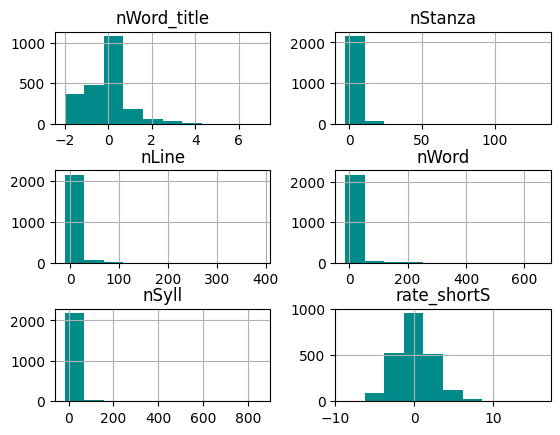

In [34]:
error_handler(lambda: histogram(robustScaled_X_train, 6))

### A gépi tanulási modellek értékelésének megalapozása

Alapvonal (baseline) meghatározása - DummyClassifier (álosztályozó)

Metrika kialakítása:
- Találati arány (accuracy)
- Pontosság (precision)
- Fedés (recall)
- F-mutató (f1_score)
- Konfúziós mátrix (számított és vizualizált)

In [35]:
dummy_clf = DummyClassifier(strategy = "stratified", random_state = 42)
print(dummy_clf.get_params(deep = True))
dummy_clf.fit(X_train, y_train)

{'constant': None, 'random_state': 42, 'strategy': 'stratified'}


DummyClassifier(random_state=42, strategy='stratified')

In [36]:
y_pred = dummy_clf.predict(X_test)
print(y_pred)
print("accuracy:", round(dummy_clf.score(X_test, y_test), 3))

[0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0
 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1
 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0
 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0
 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 0
 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0
 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0
 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0
 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1
 1 0 1 0 1 0 0 1 1 0 1 0 

In [37]:
get_clf_report(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.5932    0.5685    0.5805       336
           1     0.3908    0.4152    0.4026       224

    accuracy                         0.5071       560
   macro avg     0.4920    0.4918    0.4916       560
weighted avg     0.5122    0.5071    0.5094       560

[0.341, 0.259]
[0.234, 0.166]


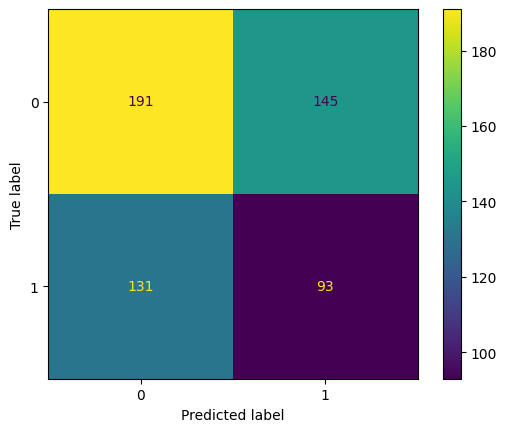

In [38]:
ConfusionMatrixDisplay.from_estimator(dummy_clf, X_test, y_test)
plt.show()

### Gépi tanulási modellek bináris osztályozási probléma megoldására

- Modellek érvényesítése k-szoros keresztvalidációval
- Paraméterek finomhangolása rácskereséssel
- A legjobb becslő kialakítása

### 1. Gauss-féle naiv Bayes modell

1.1 GNB alapmodell

In [39]:
clf1 = GaussianNB()
error_handler(lambda: cross_validate_binary_classifiers(clf1, X_train, y_train))

accuracy: 0.531, 0.562, 0.558, 0.54, 0.545, 0.527, 0.54, 0.589, 0.534, 0.529
Átlagos: 0.5456
Szórás: 0.0184
precision_macro: 0.648, 0.659, 0.688, 0.662, 0.674, 0.685, 0.662, 0.708, 0.658, 0.655
Átlagos: 0.6698
Szórás: 0.0176
recall_macro: 0.598, 0.602, 0.637, 0.6, 0.613, 0.596, 0.616, 0.647, 0.612, 0.597
Átlagos: 0.6117
Szórás: 0.0167
f1_macro: 0.512, 0.536, 0.547, 0.515, 0.525, 0.493, 0.527, 0.574, 0.52, 0.506
Átlagos: 0.5255
Szórás: 0.0217
GaussianNB() paraméterek: {'priors': None, 'var_smoothing': 1e-09}


1.2 GNB transzformált adatokkal

In [40]:
clf2 = make_pipeline(transformer, GaussianNB())
error_handler(lambda: cross_validate_binary_classifiers(clf2, X_train, y_train))

accuracy: 0.665, 0.723, 0.768, 0.705, 0.795, 0.67, 0.763, 0.75, 0.713, 0.794
Átlagos: 0.7346
Szórás: 0.0445
precision_macro: 0.681, 0.731, 0.759, 0.717, 0.792, 0.683, 0.759, 0.764, 0.711, 0.792
Átlagos: 0.739
Szórás: 0.0385
recall_macro: 0.686, 0.732, 0.774, 0.722, 0.805, 0.687, 0.775, 0.77, 0.725, 0.804
Átlagos: 0.748
Szórás: 0.0415
f1_macro: 0.665, 0.723, 0.761, 0.705, 0.792, 0.669, 0.759, 0.75, 0.708, 0.791
Átlagos: 0.7322
Szórás: 0.0434
Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('gaussiannb', GaussianNB())]) paraméterek: {'memory': None, 'steps': [('powertransformer', PowerTransformer()), ('gaussiannb', GaussianNB())], 'verbose': False, 'powertransformer': PowerTransformer(), 'gaussiannb': GaussianNB(), 'powertransformer__copy': True, 'powertransformer__method': 'yeo-johnson', 'powertransformer__standardize': True, 'gaussiannb__priors': None, 'gaussiannb__var_smoothing': 1e-09}


1.3 GNB skálázott és transzformált adatokkal (legjobb GNB)

In [41]:
clf3 = make_pipeline(scaler_robust, transformer, GaussianNB())
error_handler(lambda: cross_validate_binary_classifiers(clf3, X_train, y_train))

accuracy: 0.692, 0.746, 0.772, 0.759, 0.79, 0.661, 0.768, 0.754, 0.722, 0.803
Átlagos: 0.7467
Szórás: 0.0416
precision_macro: 0.7, 0.749, 0.763, 0.762, 0.787, 0.672, 0.76, 0.768, 0.718, 0.799
Átlagos: 0.7477
Szórás: 0.0375
recall_macro: 0.708, 0.752, 0.777, 0.771, 0.799, 0.676, 0.774, 0.774, 0.732, 0.811
Átlagos: 0.7575
Szórás: 0.0393
f1_macro: 0.691, 0.745, 0.765, 0.758, 0.787, 0.66, 0.762, 0.754, 0.716, 0.8
Átlagos: 0.7438
Szórás: 0.0408
Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('powertransformer', PowerTransformer()),
                ('gaussiannb', GaussianNB())]) paraméterek: {'memory': None, 'steps': [('robustscaler', RobustScaler(quantile_range=(0.25, 0.75))), ('powertransformer', PowerTransformer()), ('gaussiannb', GaussianNB())], 'verbose': False, 'robustscaler': RobustScaler(quantile_range=(0.25, 0.75)), 'powertransformer': PowerTransformer(), 'gaussiannb': GaussianNB(), 'robustscaler__copy': True, 'robustscaler__quantile_ran

### 2. K legközelebbi szomszéd modell (KNeighborsClassifier)

2.1 KNN alapmodell (5 szomszéd)

In [42]:
clf4 = KNeighborsClassifier(n_neighbors = 5)
error_handler(lambda: cross_validate_binary_classifiers(clf4, X_train, y_train))

accuracy: 0.714, 0.71, 0.732, 0.714, 0.777, 0.705, 0.763, 0.768, 0.744, 0.74
Átlagos: 0.7368
Szórás: 0.0247
precision_macro: 0.703, 0.705, 0.714, 0.706, 0.768, 0.699, 0.751, 0.76, 0.731, 0.731
Átlagos: 0.7269
Szórás: 0.0243
recall_macro: 0.706, 0.706, 0.707, 0.708, 0.777, 0.705, 0.761, 0.766, 0.741, 0.736
Átlagos: 0.7313
Szórás: 0.0272
f1_macro: 0.704, 0.706, 0.71, 0.707, 0.771, 0.7, 0.754, 0.762, 0.734, 0.733
Átlagos: 0.728
Szórás: 0.0253
KNeighborsClassifier() paraméterek: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


2.2 KNN transzformált adatokra, rácskereséssel

In [43]:
clf5 = Pipeline([('transformer', transformer),
                 ('clf', KNeighborsClassifier())
                 ])

param_grid_5 = {'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]  
                }

clf6 = error_handler(lambda: grid_search_with_cross_validate(clf5, param_grid_5, X_train, y_train))

{'memory': None, 'steps': [('transformer', PowerTransformer()), ('clf', KNeighborsClassifier(n_neighbors=7))], 'verbose': False, 'transformer': PowerTransformer(), 'clf': KNeighborsClassifier(n_neighbors=7), 'transformer__copy': True, 'transformer__method': 'yeo-johnson', 'transformer__standardize': True, 'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'minkowski', 'clf__metric_params': None, 'clf__n_jobs': None, 'clf__n_neighbors': 7, 'clf__p': 2, 'clf__weights': 'uniform'}


In [44]:
cross_validate_binary_classifiers(clf6, X_train, y_train)

accuracy: 0.772, 0.799, 0.812, 0.799, 0.826, 0.79, 0.799, 0.821, 0.74, 0.848
Átlagos: 0.8007
Szórás: 0.0283
precision_macro: 0.763, 0.796, 0.799, 0.797, 0.819, 0.785, 0.788, 0.815, 0.724, 0.84
Átlagos: 0.7927
Szórás: 0.0302
recall_macro: 0.769, 0.794, 0.805, 0.783, 0.829, 0.794, 0.799, 0.824, 0.73, 0.847
Átlagos: 0.7974
Szórás: 0.0312
f1_macro: 0.765, 0.795, 0.802, 0.788, 0.822, 0.787, 0.791, 0.818, 0.727, 0.843
Átlagos: 0.7937
Szórás: 0.0303
Pipeline(steps=[('transformer', PowerTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=7))]) paraméterek: {'memory': None, 'steps': [('transformer', PowerTransformer()), ('clf', KNeighborsClassifier(n_neighbors=7))], 'verbose': False, 'transformer': PowerTransformer(), 'clf': KNeighborsClassifier(n_neighbors=7), 'transformer__copy': True, 'transformer__method': 'yeo-johnson', 'transformer__standardize': True, 'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'minkowski', 'clf__metric_params': None, 'clf__n_jobs'

2.3 KNN jellemző kiválasztással, transzformált adatokra (legjobb KNN)

In [45]:
clf5_rf = Pipeline([("select", SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42), threshold = f'{2.0} * median')),
                    ('transformer', transformer),
                    ('clf', KNeighborsClassifier(n_neighbors = 5))
                    ])

cross_validate_binary_classifiers(clf5_rf, X_train, y_train)

accuracy: 0.826, 0.799, 0.848, 0.879, 0.862, 0.817, 0.808, 0.826, 0.812, 0.861
Átlagos: 0.8338
Szórás: 0.0256
precision_macro: 0.819, 0.796, 0.838, 0.875, 0.854, 0.814, 0.798, 0.823, 0.799, 0.855
Átlagos: 0.8271
Szórás: 0.026
recall_macro: 0.831, 0.796, 0.838, 0.878, 0.864, 0.825, 0.811, 0.834, 0.807, 0.867
Átlagos: 0.8352
Szórás: 0.026
f1_macro: 0.822, 0.796, 0.838, 0.876, 0.858, 0.815, 0.801, 0.824, 0.802, 0.858
Átlagos: 0.829
Szórás: 0.0261
Pipeline(steps=[('select',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                 threshold='2.0 * median')),
                ('transformer', PowerTransformer()),
                ('clf', KNeighborsClassifier())]) paraméterek: {'memory': None, 'steps': [('select', SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='2.0 * median')), ('transformer', PowerTransformer()), ('clf', KNeighborsClassifier())], 'verbose': False, 'select': SelectFromModel(

### PCA - főkomponens analízis hatása

Nem felügyelt gépi tanulási modell

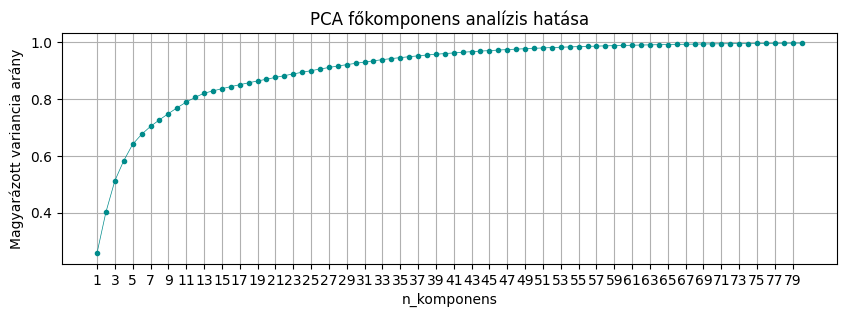

In [46]:
nums = np.arange(1, 81, 1)
var_ratio = []

for num in nums:
    pca = PCA(n_components = num)
    pca.fit(standardScaled_X_train)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize = (10, 3))
plt.grid()
plt.plot(nums, var_ratio, marker = 'o', markersize = 3, color = 'darkcyan', linewidth = 0.5)
plt.xlabel('n_komponens')
plt.ylabel('Magyarázott variancia arány')
plt.title('PCA főkomponens analízis hatása')
plt.xticks(np.arange(1, 81, 2))
plt.show()

2.4 KNN főkomponens analízissel

In [47]:
clf7 = make_pipeline(transformer, 
                     PCA(n_components = 78), 
                     KNeighborsClassifier(n_neighbors = 11)
                     )

error_handler(lambda: cross_validate_binary_classifiers(clf7, X_train, y_train))

accuracy: 0.763, 0.79, 0.812, 0.808, 0.812, 0.799, 0.781, 0.853, 0.753, 0.857
Átlagos: 0.803
Szórás: 0.032
precision_macro: 0.755, 0.787, 0.801, 0.802, 0.807, 0.793, 0.77, 0.847, 0.739, 0.85
Átlagos: 0.7951
Szórás: 0.0338
recall_macro: 0.764, 0.787, 0.798, 0.799, 0.82, 0.801, 0.78, 0.857, 0.746, 0.852
Átlagos: 0.8004
Szórás: 0.0335
f1_macro: 0.757, 0.787, 0.799, 0.801, 0.809, 0.795, 0.773, 0.85, 0.741, 0.851
Átlagos: 0.7964
Szórás: 0.0335
Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('pca', PCA(n_components=78)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=11))]) paraméterek: {'memory': None, 'steps': [('powertransformer', PowerTransformer()), ('pca', PCA(n_components=78)), ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=11))], 'verbose': False, 'powertransformer': PowerTransformer(), 'pca': PCA(n_components=78), 'kneighborsclassifier': KNeighborsClassifier(n_neighbors=11), 'powertransformer__copy': True, 'powertransf

### Lineáris modellek

3.1 Logisztikus regresszió (LogisticRegression) - (legjobb LR)

Skálázott és transzformált adatokkal

In [48]:
clf8 = Pipeline([('scaler', scaler_robust),
                 ('transformer', transformer),
                 ('logReg', LogisticRegression(solver = 'liblinear', random_state = 42))
                 ])

error_handler(lambda: cross_validate_binary_classifiers(clf8, X_train, y_train))

accuracy: 0.812, 0.799, 0.772, 0.817, 0.826, 0.804, 0.808, 0.844, 0.848, 0.825
Átlagos: 0.8155
Szórás: 0.0209
precision_macro: 0.804, 0.797, 0.759, 0.811, 0.819, 0.797, 0.802, 0.839, 0.84, 0.821
Átlagos: 0.8087
Szórás: 0.0224
recall_macro: 0.806, 0.793, 0.749, 0.812, 0.817, 0.795, 0.784, 0.835, 0.833, 0.811
Átlagos: 0.8035
Szórás: 0.024
f1_macro: 0.805, 0.795, 0.753, 0.811, 0.818, 0.796, 0.79, 0.837, 0.836, 0.815
Átlagos: 0.8056
Szórás: 0.0233
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('logReg',
                 LogisticRegression(random_state=42, solver='liblinear'))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('logReg', LogisticRegression(random_state=42, solver='liblinear'))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'logReg': Logisti

3.2 LR statisztikai alapú jellemző kiválasztással

A SelectKBest hatásának elemzése adatvizualizációval

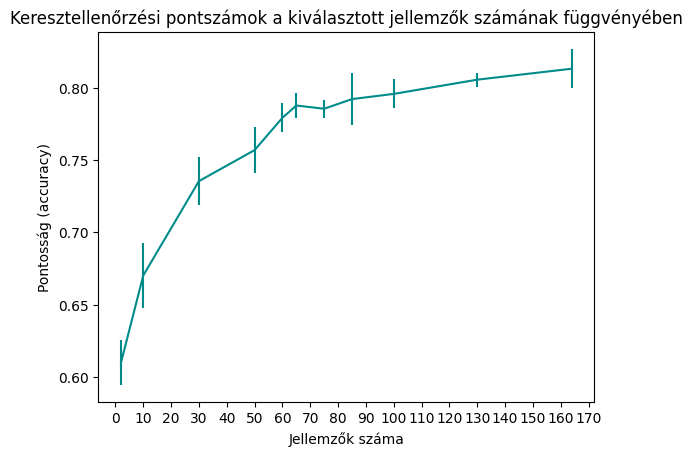

In [49]:
clf8_s = Pipeline([("select", SelectKBest(f_classif)),
                   ('scaler', scaler_robust),
                   ('transformer', transformer),
                   ('logReg', LogisticRegression(solver = 'liblinear', random_state = 42))
                   ])

k_values = (2, 10, 30, 50, 60, 65, 75, 85, 100, 130, 164)

error_handler(lambda: accuracy_by_feature_num(k_values, clf8_s, X_train, y_train))

3.3 LR modell alapú jellemző kiválasztással

In [50]:
clf8_r = Pipeline([("select", SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42), threshold = f'{0.5} * median')),
                   ('scaler', scaler_robust),
                   ('transformer', transformer),
                   ('logReg', LogisticRegression(solver = 'liblinear', random_state = 42))
                   ])

cross_validate_binary_classifiers(clf8_r, X_train, y_train)

accuracy: 0.812, 0.768, 0.781, 0.808, 0.835, 0.812, 0.804, 0.844, 0.821, 0.821
Átlagos: 0.8106
Szórás: 0.0215
precision_macro: 0.804, 0.765, 0.768, 0.802, 0.829, 0.805, 0.796, 0.838, 0.81, 0.818
Átlagos: 0.8034
Szórás: 0.0222
recall_macro: 0.81, 0.762, 0.761, 0.801, 0.825, 0.807, 0.78, 0.839, 0.807, 0.804
Átlagos: 0.7995
Szórás: 0.0239
f1_macro: 0.806, 0.763, 0.764, 0.801, 0.827, 0.806, 0.786, 0.838, 0.808, 0.809
Átlagos: 0.8009
Szórás: 0.023
Pipeline(steps=[('select',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                 threshold='0.5 * median')),
                ('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('logReg',
                 LogisticRegression(random_state=42, solver='liblinear'))]) paraméterek: {'memory': None, 'steps': [('select', SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='0.5 * med

3.4 LR paraméterhangolás rácskereséssel

In [51]:
param_grid_8 = {'logReg__C': [0.1, 1, 2, 5, 10]
                }

clf9 = error_handler(lambda: grid_search_with_cross_validate(clf8, param_grid_8, X_train, y_train))

{'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('logReg', LogisticRegression(C=10, random_state=42, solver='liblinear'))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'logReg': LogisticRegression(C=10, random_state=42, solver='liblinear'), 'scaler__copy': True, 'scaler__quantile_range': (0.25, 0.75), 'scaler__unit_variance': False, 'scaler__with_centering': True, 'scaler__with_scaling': True, 'transformer__copy': True, 'transformer__method': 'yeo-johnson', 'transformer__standardize': True, 'logReg__C': 10, 'logReg__class_weight': None, 'logReg__dual': False, 'logReg__fit_intercept': True, 'logReg__intercept_scaling': 1, 'logReg__l1_ratio': None, 'logReg__max_iter': 100, 'logReg__multi_class': 'auto', 'logReg__n_jobs': None, 'logReg__penalty': 'l2', 'logReg__random_state': 42, 'logReg__solver': 'liblinear', 'logReg__tol': 0.0001, 'logReg__verbose': 0, 'lo

In [52]:
error_handler(lambda: cross_validate_binary_classifiers(clf9, X_train, y_train))

accuracy: 0.821, 0.786, 0.763, 0.826, 0.835, 0.812, 0.799, 0.835, 0.861, 0.83
Átlagos: 0.8168
Szórás: 0.0265
precision_macro: 0.814, 0.783, 0.748, 0.82, 0.827, 0.806, 0.79, 0.829, 0.854, 0.824
Átlagos: 0.8093
Szórás: 0.0281
recall_macro: 0.814, 0.781, 0.744, 0.823, 0.829, 0.806, 0.776, 0.83, 0.848, 0.819
Átlagos: 0.8069
Szórás: 0.0295
f1_macro: 0.814, 0.782, 0.746, 0.821, 0.828, 0.806, 0.782, 0.829, 0.851, 0.821
Átlagos: 0.8078
Szórás: 0.0288
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('logReg',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('logReg', LogisticRegression(C=10, random_state=42, solver='liblinear'))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'tran

4.1 Lineáris támogatási vektor osztályozó (Linear Support Vector Classifier - LinearSVC)

Skálázott és transzformált adatokkal

In [53]:
clf10 = Pipeline([('scaler', scaler_robust),
                  ('transformer', transformer),
                  ('linSVC', LinearSVC(dual = 'auto', random_state = 42))
                  ])

error_handler(lambda: cross_validate_binary_classifiers(clf10, X_train, y_train))

accuracy: 0.821, 0.795, 0.763, 0.83, 0.83, 0.804, 0.808, 0.835, 0.857, 0.83
Átlagos: 0.8173
Szórás: 0.0246
precision_macro: 0.814, 0.792, 0.748, 0.824, 0.822, 0.796, 0.8, 0.829, 0.848, 0.823
Átlagos: 0.8097
Szórás: 0.0261
recall_macro: 0.814, 0.79, 0.742, 0.826, 0.825, 0.796, 0.786, 0.83, 0.845, 0.82
Átlagos: 0.8074
Szórás: 0.0282
f1_macro: 0.814, 0.791, 0.744, 0.825, 0.824, 0.796, 0.792, 0.829, 0.846, 0.822
Átlagos: 0.8083
Szórás: 0.0272
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('linSVC', LinearSVC(dual='auto', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('linSVC', LinearSVC(dual='auto', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'linSVC': LinearSVC(dual='auto', random_state=42), 'scaler__copy': True

### 5. Támasz vektor gépek (Support Vector Machines - SVC)

5.1 SVC lineáris kernellel

Skálázott és transzformált adatokkal

In [54]:
clf11 = Pipeline([('scaler', scaler_robust),
                  ('transformer', transformer),
                  ('svc', SVC(kernel = 'linear', random_state = 42))  
                  ])

error_handler(lambda: cross_validate_binary_classifiers(clf11, X_train, y_train))

accuracy: 0.821, 0.799, 0.786, 0.799, 0.857, 0.804, 0.795, 0.853, 0.852, 0.83
Átlagos: 0.8195
Szórás: 0.0255
precision_macro: 0.814, 0.797, 0.772, 0.793, 0.85, 0.796, 0.785, 0.847, 0.845, 0.822
Átlagos: 0.8121
Szórás: 0.0266
recall_macro: 0.814, 0.793, 0.767, 0.792, 0.853, 0.796, 0.773, 0.848, 0.837, 0.824
Átlagos: 0.8096
Szórás: 0.0288
f1_macro: 0.814, 0.795, 0.769, 0.792, 0.851, 0.796, 0.778, 0.848, 0.84, 0.823
Átlagos: 0.8106
Szórás: 0.0277
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(kernel='linear', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(kernel='linear', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(kernel='linear', random_state=42), 'scaler__copy': True, 'scaler_

5.2 SVC polinomiális kernellel

Skálázott és transzformált adatokkal

In [55]:
clf12 = Pipeline([('scaler', scaler_robust), 
                  ('transformer', transformer), 
                  ('svc', SVC(kernel = 'poly', random_state = 42))  
                  ])

error_handler(lambda: cross_validate_binary_classifiers(clf12, X_train, y_train))

accuracy: 0.777, 0.79, 0.795, 0.781, 0.799, 0.768, 0.804, 0.817, 0.776, 0.834
Átlagos: 0.794
Szórás: 0.0193
precision_macro: 0.767, 0.788, 0.781, 0.774, 0.79, 0.76, 0.791, 0.811, 0.764, 0.826
Átlagos: 0.7853
Szórás: 0.0199
recall_macro: 0.771, 0.784, 0.786, 0.773, 0.797, 0.766, 0.798, 0.809, 0.775, 0.83
Átlagos: 0.789
Szórás: 0.0188
f1_macro: 0.769, 0.786, 0.783, 0.774, 0.793, 0.762, 0.794, 0.81, 0.767, 0.828
Átlagos: 0.7865
Szórás: 0.0196
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(kernel='poly', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(kernel='poly', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(kernel='poly', random_state=42), 'scaler__copy': True, 'scaler__quantile_

5.3 SVC Gauss-féle radiális bázisfüggvény használatával (rbf kernel)

Skálázott és transzformált adatokkal

In [56]:
clf13 = Pipeline([('scaler', scaler_robust), 
                  ('transformer', transformer), 
                  ('svc', SVC(random_state = 42))  
                  ])

error_handler(lambda: cross_validate_binary_classifiers(clf13, X_train, y_train))

accuracy: 0.79, 0.821, 0.817, 0.862, 0.871, 0.821, 0.857, 0.857, 0.834, 0.883
Átlagos: 0.8414
Szórás: 0.0275
precision_macro: 0.782, 0.824, 0.815, 0.863, 0.872, 0.816, 0.856, 0.855, 0.831, 0.881
Átlagos: 0.8396
Szórás: 0.0292
recall_macro: 0.776, 0.812, 0.787, 0.85, 0.856, 0.811, 0.837, 0.847, 0.81, 0.875
Átlagos: 0.8261
Szórás: 0.0301
f1_macro: 0.779, 0.816, 0.797, 0.855, 0.862, 0.814, 0.844, 0.85, 0.818, 0.877
Átlagos: 0.8312
Szórás: 0.0298
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(random_state=42), 'scaler__copy': True, 'scaler__quantile_range': (0.25, 0.75), 'scaler__unit_varian

5.4 SVC (rbf kernel) paraméter hangolása rácskereséssel (legjobb SVC)

In [57]:
param_grid_13 = {'svc__C': [1, 5, 10, 20, 30]
                 }

clf14 = error_handler(lambda: grid_search_with_cross_validate(clf13, param_grid_13, X_train, y_train))

{'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(C=10, random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(C=10, random_state=42), 'scaler__copy': True, 'scaler__quantile_range': (0.25, 0.75), 'scaler__unit_variance': False, 'scaler__with_centering': True, 'scaler__with_scaling': True, 'transformer__copy': True, 'transformer__method': 'yeo-johnson', 'transformer__standardize': True, 'svc__C': 10, 'svc__break_ties': False, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovr', 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__max_iter': -1, 'svc__probability': False, 'svc__random_state': 42, 'svc__shrinking': True, 'svc__tol': 0.001, 'svc__verbose': False}


In [58]:
error_handler(lambda: cross_validate_binary_classifiers(clf14, X_train, y_train))

accuracy: 0.835, 0.83, 0.821, 0.871, 0.866, 0.835, 0.862, 0.866, 0.87, 0.852
Átlagos: 0.8508
Szórás: 0.0177
precision_macro: 0.828, 0.832, 0.811, 0.869, 0.861, 0.829, 0.854, 0.863, 0.863, 0.847
Átlagos: 0.8457
Szórás: 0.0186
recall_macro: 0.827, 0.822, 0.805, 0.862, 0.858, 0.83, 0.852, 0.858, 0.858, 0.843
Átlagos: 0.8414
Szórás: 0.0186
f1_macro: 0.827, 0.825, 0.808, 0.865, 0.86, 0.829, 0.853, 0.86, 0.861, 0.845
Átlagos: 0.8432
Szórás: 0.0186
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(C=10, random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(C=10, random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(C=10, random_state=42), 'scaler__copy': True, 'scaler__quantile_range': (0.25, 0.75), 'sc

5.5 SVC statisztikai alapú jellemző kiválasztással

In [59]:
clf14_s = Pipeline([("select", SelectKBest(f_classif)),
                    ("scaler", scaler_robust),
                    ('transformer', transformer),
                    ("svc", SVC(C = 10, random_state = 42)),
                    ])

error_handler(lambda: accuracy_by_feature_num(k_values, clf14_s, X_train, y_train))

KeyboardInterrupt: 

### Együttes (ensemble) modellek

6.1 Véletlen erdő (RandomForestClassifier) rácskereséssel (legjobb RFC)

In [ ]:
clf15 = Pipeline([('randomForest', RandomForestClassifier(random_state = 42))
                    ])

param_grid_15 = {'randomForest__n_estimators': [100, 150, 200, 250, 300],
                 'randomForest__max_features': [13, 14, 15]
                 }

clf16 = error_handler(lambda: grid_search_with_cross_validate(clf15, param_grid_15, X_train, y_train))

{'memory': None, 'steps': [('randomForest', RandomForestClassifier(max_features=14, n_estimators=200, random_state=42))], 'verbose': False, 'randomForest': RandomForestClassifier(max_features=14, n_estimators=200, random_state=42), 'randomForest__bootstrap': True, 'randomForest__ccp_alpha': 0.0, 'randomForest__class_weight': None, 'randomForest__criterion': 'gini', 'randomForest__max_depth': None, 'randomForest__max_features': 14, 'randomForest__max_leaf_nodes': None, 'randomForest__max_samples': None, 'randomForest__min_impurity_decrease': 0.0, 'randomForest__min_samples_leaf': 1, 'randomForest__min_samples_split': 2, 'randomForest__min_weight_fraction_leaf': 0.0, 'randomForest__monotonic_cst': None, 'randomForest__n_estimators': 200, 'randomForest__n_jobs': None, 'randomForest__oob_score': False, 'randomForest__random_state': 42, 'randomForest__verbose': 0, 'randomForest__warm_start': False}


In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf16, X_train, y_train))

accuracy: 0.857, 0.848, 0.862, 0.875, 0.888, 0.866, 0.871, 0.871, 0.874, 0.892
Átlagos: 0.8704
Szórás: 0.0127
precision_macro: 0.863, 0.855, 0.865, 0.89, 0.9, 0.868, 0.882, 0.874, 0.885, 0.89
Átlagos: 0.8772
Szórás: 0.0137
recall_macro: 0.837, 0.838, 0.837, 0.856, 0.869, 0.853, 0.843, 0.856, 0.847, 0.884
Átlagos: 0.8521
Szórás: 0.0145
f1_macro: 0.846, 0.843, 0.847, 0.866, 0.879, 0.858, 0.856, 0.863, 0.86, 0.887
Átlagos: 0.8606
Szórás: 0.0135
Pipeline(steps=[('randomForest',
                 RandomForestClassifier(max_features=14, n_estimators=200,
                                        random_state=42))]) paraméterek: {'memory': None, 'steps': [('randomForest', RandomForestClassifier(max_features=14, n_estimators=200, random_state=42))], 'verbose': False, 'randomForest': RandomForestClassifier(max_features=14, n_estimators=200, random_state=42), 'randomForest__bootstrap': True, 'randomForest__ccp_alpha': 0.0, 'randomForest__class_weight': None, 'randomForest__criterion': 'gini', 'rand

7.1 Gradiens növelő (GradientBoosting) osztályozó alapmodell

In [ ]:
clf17 = GradientBoostingClassifier(random_state = 42) 

error_handler(lambda: cross_validate_binary_classifiers(clf17, X_train, y_train))

accuracy: 0.866, 0.826, 0.866, 0.911, 0.893, 0.888, 0.879, 0.893, 0.883, 0.906
Átlagos: 0.8812
Szórás: 0.0231
precision_macro: 0.862, 0.823, 0.866, 0.909, 0.891, 0.886, 0.88, 0.891, 0.886, 0.901
Átlagos: 0.8795
Szórás: 0.0232
recall_macro: 0.856, 0.824, 0.845, 0.906, 0.884, 0.882, 0.862, 0.885, 0.864, 0.903
Átlagos: 0.8712
Szórás: 0.0245
f1_macro: 0.859, 0.823, 0.853, 0.907, 0.887, 0.884, 0.869, 0.888, 0.873, 0.902
Átlagos: 0.8746
Szórás: 0.0237
GradientBoostingClassifier(random_state=42) paraméterek: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


7.2 GBC manuális paraméterhangolással (legjobb GBC)

In [ ]:
clf18 = GradientBoostingClassifier(n_estimators = 250, max_depth = 4, random_state = 42) 

error_handler(lambda: cross_validate_binary_classifiers(clf18, X_train, y_train))

accuracy: 0.866, 0.866, 0.884, 0.902, 0.888, 0.897, 0.888, 0.902, 0.892, 0.91
Átlagos: 0.8896
Szórás: 0.0139
precision_macro: 0.86, 0.864, 0.883, 0.9, 0.885, 0.897, 0.89, 0.905, 0.893, 0.907
Átlagos: 0.8883
Szórás: 0.015
recall_macro: 0.86, 0.864, 0.867, 0.897, 0.881, 0.889, 0.871, 0.891, 0.876, 0.907
Átlagos: 0.8803
Szórás: 0.0146
f1_macro: 0.86, 0.864, 0.874, 0.898, 0.883, 0.893, 0.879, 0.897, 0.883, 0.907
Átlagos: 0.8836
Szórás: 0.0143
GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=42) paraméterek: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


8.1 AdaBoostClassifier manuális paraméterhangolással (legjobb ABC)

In [ ]:
clf19 = AdaBoostClassifier(n_estimators = 250, learning_rate = 0.9, algorithm = 'SAMME', random_state = 42)

error_handler(lambda: cross_validate_binary_classifiers(clf19, X_train, y_train))

accuracy: 0.862, 0.835, 0.853, 0.888, 0.866, 0.897, 0.871, 0.888, 0.87, 0.888
Átlagos: 0.8718
Szórás: 0.0183
precision_macro: 0.856, 0.832, 0.852, 0.884, 0.864, 0.893, 0.864, 0.883, 0.86, 0.883
Átlagos: 0.8671
Szórás: 0.0175
recall_macro: 0.855, 0.832, 0.83, 0.887, 0.854, 0.894, 0.859, 0.887, 0.865, 0.884
Átlagos: 0.8647
Szórás: 0.0219
f1_macro: 0.855, 0.832, 0.838, 0.885, 0.858, 0.894, 0.862, 0.885, 0.862, 0.883
Átlagos: 0.8655
Szórás: 0.0198
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9, n_estimators=250,
                   random_state=42) paraméterek: {'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 0.9, 'n_estimators': 250, 'random_state': 42}


9.1 Szavazó (Voting) osztályozó

In [ ]:
# clf_lr = LogisticRegression(solver = 'lbfgs', max_iter = 3000, random_state = 42)
# clf_rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
# clf_gnb = GaussianNB()

clf20 = VotingClassifier(estimators = [('ga', clf3), ('knn', clf6), ('svc_poly', clf12)] 
                         )

error_handler(lambda: cross_validate_binary_classifiers(clf20, X_train, y_train))

accuracy: 0.772, 0.821, 0.821, 0.795, 0.804, 0.759, 0.799, 0.844, 0.758, 0.843
Átlagos: 0.8016
Szórás: 0.0299
precision_macro: 0.764, 0.818, 0.809, 0.788, 0.796, 0.755, 0.788, 0.838, 0.748, 0.836
Átlagos: 0.7938
Szórás: 0.0302
recall_macro: 0.771, 0.82, 0.819, 0.79, 0.804, 0.764, 0.799, 0.846, 0.761, 0.845
Átlagos: 0.8019
Szórás: 0.0294
f1_macro: 0.766, 0.819, 0.813, 0.789, 0.798, 0.756, 0.791, 0.84, 0.75, 0.839
Átlagos: 0.7961
Szórás: 0.0305
VotingClassifier(estimators=[('ga',
                              Pipeline(steps=[('robustscaler',
                                               RobustScaler(quantile_range=(0.25,
                                                                            0.75))),
                                              ('powertransformer',
                                               PowerTransformer()),
                                              ('gaussiannb', GaussianNB())])),
                             ('knn',
                              Pipeli

### Osztályozó modellek k-szoros keresztvalidációja kiegyensúlyozott osztályok esetén

GNB

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf3, X_train_balanced, y_train_balanced))

accuracy: 0.81, 0.704, 0.715, 0.782, 0.732, 0.693, 0.726, 0.771, 0.732, 0.77
Átlagos: 0.7434
Szórás: 0.0359
precision_macro: 0.814, 0.704, 0.718, 0.781, 0.735, 0.702, 0.724, 0.776, 0.728, 0.767
Átlagos: 0.7448
Szórás: 0.0357
recall_macro: 0.806, 0.704, 0.704, 0.777, 0.731, 0.697, 0.732, 0.776, 0.735, 0.767
Átlagos: 0.7429
Szórás: 0.035
f1_macro: 0.807, 0.704, 0.706, 0.778, 0.73, 0.692, 0.723, 0.771, 0.728, 0.767
Átlagos: 0.7406
Szórás: 0.0361
Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('powertransformer', PowerTransformer()),
                ('gaussiannb', GaussianNB())]) paraméterek: {'memory': None, 'steps': [('robustscaler', RobustScaler(quantile_range=(0.25, 0.75))), ('powertransformer', PowerTransformer()), ('gaussiannb', GaussianNB())], 'verbose': False, 'robustscaler': RobustScaler(quantile_range=(0.25, 0.75)), 'powertransformer': PowerTransformer(), 'gaussiannb': GaussianNB(), 'robustscaler__copy': True, 'robustscaler__quantile_

KNN

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf6, X_train_balanced, y_train_balanced))

accuracy: 0.81, 0.771, 0.76, 0.754, 0.799, 0.765, 0.782, 0.821, 0.793, 0.781
Átlagos: 0.7837
Szórás: 0.0209
precision_macro: 0.81, 0.771, 0.758, 0.751, 0.799, 0.781, 0.775, 0.823, 0.796, 0.779
Átlagos: 0.7844
Szórás: 0.0213
recall_macro: 0.808, 0.771, 0.755, 0.751, 0.799, 0.771, 0.784, 0.825, 0.806, 0.777
Átlagos: 0.7846
Szórás: 0.0229
f1_macro: 0.809, 0.771, 0.756, 0.751, 0.799, 0.764, 0.777, 0.821, 0.792, 0.778
Átlagos: 0.7818
Szórás: 0.0217
Pipeline(steps=[('transformer', PowerTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=7))]) paraméterek: {'memory': None, 'steps': [('transformer', PowerTransformer()), ('clf', KNeighborsClassifier(n_neighbors=7))], 'verbose': False, 'transformer': PowerTransformer(), 'clf': KNeighborsClassifier(n_neighbors=7), 'transformer__copy': True, 'transformer__method': 'yeo-johnson', 'transformer__standardize': True, 'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'minkowski', 'clf__metric_params': None, 'clf__n_jobs

LogReg

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf8, X_train_balanced, y_train_balanced))

accuracy: 0.799, 0.782, 0.816, 0.788, 0.849, 0.793, 0.793, 0.804, 0.804, 0.809
Átlagos: 0.8038
Szórás: 0.0179
precision_macro: 0.798, 0.784, 0.814, 0.785, 0.849, 0.793, 0.786, 0.803, 0.8, 0.813
Átlagos: 0.8025
Szórás: 0.0186
recall_macro: 0.799, 0.781, 0.814, 0.785, 0.849, 0.794, 0.793, 0.805, 0.792, 0.815
Átlagos: 0.8028
Szórás: 0.0188
f1_macro: 0.799, 0.781, 0.814, 0.785, 0.849, 0.793, 0.788, 0.804, 0.795, 0.809
Átlagos: 0.8017
Szórás: 0.0186
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('logReg',
                 LogisticRegression(random_state=42, solver='liblinear'))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('logReg', LogisticRegression(random_state=42, solver='liblinear'))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'logReg': Logist

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf9, X_train_balanced, y_train_balanced))

accuracy: 0.821, 0.777, 0.816, 0.788, 0.849, 0.771, 0.793, 0.816, 0.821, 0.809
Átlagos: 0.806
Szórás: 0.0226
precision_macro: 0.821, 0.777, 0.814, 0.786, 0.849, 0.771, 0.785, 0.814, 0.817, 0.81
Átlagos: 0.8044
Szórás: 0.0229
recall_macro: 0.822, 0.776, 0.813, 0.784, 0.849, 0.772, 0.791, 0.814, 0.811, 0.813
Átlagos: 0.8044
Szórás: 0.0225
f1_macro: 0.821, 0.776, 0.814, 0.785, 0.849, 0.771, 0.787, 0.814, 0.813, 0.809
Átlagos: 0.8039
Szórás: 0.0227
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('logReg',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('logReg', LogisticRegression(C=10, random_state=42, solver='liblinear'))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'tr

LinSVC

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf10, X_train_balanced, y_train_balanced))

accuracy: 0.821, 0.765, 0.81, 0.782, 0.849, 0.777, 0.782, 0.827, 0.821, 0.815
Átlagos: 0.8049
Szórás: 0.0255
precision_macro: 0.821, 0.766, 0.808, 0.78, 0.849, 0.776, 0.774, 0.826, 0.817, 0.816
Átlagos: 0.8033
Szórás: 0.0262
recall_macro: 0.822, 0.765, 0.808, 0.779, 0.849, 0.777, 0.779, 0.825, 0.811, 0.819
Átlagos: 0.8034
Szórás: 0.0258
f1_macro: 0.821, 0.765, 0.808, 0.779, 0.849, 0.776, 0.776, 0.825, 0.813, 0.814
Átlagos: 0.8028
Szórás: 0.0259
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('linSVC', LinearSVC(dual='auto', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('linSVC', LinearSVC(dual='auto', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'linSVC': LinearSVC(dual='auto', random_state=42), 'scaler__copy'

SVC (linear kernel)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf11, X_train_balanced, y_train_balanced))

accuracy: 0.816, 0.765, 0.799, 0.782, 0.855, 0.782, 0.76, 0.816, 0.832, 0.798
Átlagos: 0.8004
Szórás: 0.0283
precision_macro: 0.815, 0.766, 0.798, 0.78, 0.855, 0.783, 0.753, 0.814, 0.83, 0.796
Átlagos: 0.7991
Szórás: 0.029
recall_macro: 0.816, 0.764, 0.795, 0.781, 0.855, 0.784, 0.76, 0.815, 0.82, 0.799
Átlagos: 0.7989
Szórás: 0.0271
f1_macro: 0.815, 0.764, 0.796, 0.78, 0.855, 0.782, 0.755, 0.815, 0.824, 0.797
Átlagos: 0.7983
Szórás: 0.0284
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(kernel='linear', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(kernel='linear', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(kernel='linear', random_state=42), 'scaler__copy': True, 'scaler__qua

SVC (polynomial kernel)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf12, X_train_balanced, y_train_balanced))

accuracy: 0.788, 0.732, 0.76, 0.737, 0.782, 0.698, 0.715, 0.737, 0.721, 0.753
Átlagos: 0.7423
Szórás: 0.0271
precision_macro: 0.816, 0.753, 0.791, 0.751, 0.799, 0.747, 0.748, 0.782, 0.744, 0.771
Átlagos: 0.7703
Szórás: 0.0242
recall_macro: 0.778, 0.728, 0.742, 0.721, 0.78, 0.709, 0.746, 0.753, 0.745, 0.736
Átlagos: 0.7437
Szórás: 0.0216
f1_macro: 0.778, 0.724, 0.743, 0.722, 0.778, 0.689, 0.715, 0.733, 0.721, 0.738
Átlagos: 0.7341
Szórás: 0.0261
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(kernel='poly', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(kernel='poly', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(kernel='poly', random_state=42), 'scaler__copy': True, 'scaler__quan

SVC (rbf kernel)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf14, X_train_balanced, y_train_balanced))

accuracy: 0.821, 0.827, 0.827, 0.793, 0.844, 0.81, 0.821, 0.832, 0.844, 0.815
Átlagos: 0.8234
Szórás: 0.0145
precision_macro: 0.821, 0.828, 0.825, 0.792, 0.844, 0.81, 0.814, 0.831, 0.837, 0.814
Átlagos: 0.8216
Szórás: 0.0142
recall_macro: 0.821, 0.828, 0.826, 0.795, 0.843, 0.811, 0.814, 0.833, 0.842, 0.817
Átlagos: 0.823
Szórás: 0.014
f1_macro: 0.821, 0.827, 0.825, 0.792, 0.843, 0.81, 0.814, 0.832, 0.839, 0.814
Átlagos: 0.8218
Szórás: 0.0143
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(C=10, random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(C=10, random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(C=10, random_state=42), 'scaler__copy': True, 'scaler__quantile_range': (0.25, 0.75), 'sc

RFC

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf16, X_train_balanced, y_train_balanced))

accuracy: 0.883, 0.849, 0.832, 0.832, 0.855, 0.832, 0.866, 0.877, 0.838, 0.843
Átlagos: 0.8508
Szórás: 0.0179
precision_macro: 0.886, 0.854, 0.831, 0.833, 0.859, 0.832, 0.868, 0.879, 0.837, 0.849
Átlagos: 0.8528
Szórás: 0.019
recall_macro: 0.886, 0.851, 0.834, 0.836, 0.856, 0.833, 0.852, 0.873, 0.825, 0.85
Átlagos: 0.8496
Szórás: 0.018
f1_macro: 0.883, 0.849, 0.832, 0.832, 0.855, 0.832, 0.858, 0.875, 0.829, 0.843
Átlagos: 0.8487
Szórás: 0.018
Pipeline(steps=[('randomForest',
                 RandomForestClassifier(max_features=14, n_estimators=200,
                                        random_state=42))]) paraméterek: {'memory': None, 'steps': [('randomForest', RandomForestClassifier(max_features=14, n_estimators=200, random_state=42))], 'verbose': False, 'randomForest': RandomForestClassifier(max_features=14, n_estimators=200, random_state=42), 'randomForest__bootstrap': True, 'randomForest__ccp_alpha': 0.0, 'randomForest__class_weight': None, 'randomForest__criterion': 'gini', 'ran

GBC

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf18, X_train_balanced, y_train_balanced))

accuracy: 0.888, 0.899, 0.849, 0.872, 0.888, 0.86, 0.894, 0.86, 0.86, 0.893
Átlagos: 0.8765
Szórás: 0.0172
precision_macro: 0.891, 0.9, 0.849, 0.87, 0.888, 0.86, 0.89, 0.859, 0.857, 0.896
Átlagos: 0.8762
Szórás: 0.0179
recall_macro: 0.891, 0.899, 0.846, 0.874, 0.888, 0.861, 0.888, 0.86, 0.852, 0.9
Átlagos: 0.8761
Szórás: 0.0189
f1_macro: 0.888, 0.899, 0.847, 0.871, 0.888, 0.86, 0.889, 0.859, 0.854, 0.893
Átlagos: 0.8751
Szórás: 0.0177
GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=42) paraméterek: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


AdaBoost

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf19, X_train_balanced, y_train_balanced))

accuracy: 0.877, 0.86, 0.838, 0.827, 0.86, 0.816, 0.86, 0.827, 0.832, 0.893
Átlagos: 0.8491
Szórás: 0.0237
precision_macro: 0.876, 0.861, 0.842, 0.826, 0.86, 0.819, 0.858, 0.831, 0.829, 0.892
Átlagos: 0.8494
Szórás: 0.0228
recall_macro: 0.877, 0.86, 0.832, 0.829, 0.86, 0.818, 0.849, 0.832, 0.822, 0.895
Átlagos: 0.8474
Szórás: 0.0241
f1_macro: 0.877, 0.86, 0.834, 0.826, 0.86, 0.816, 0.853, 0.827, 0.825, 0.893
Átlagos: 0.8471
Szórás: 0.0242
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9, n_estimators=250,
                   random_state=42) paraméterek: {'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 0.9, 'n_estimators': 250, 'random_state': 42}


### Osztályozó modellek k-szoros keresztvalidációja szelektált jellemzőtér esetén

GNB saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf3, X_train_top, y_train_top))

accuracy: 0.804, 0.795, 0.826, 0.853, 0.862, 0.826, 0.83, 0.799, 0.839, 0.834
Átlagos: 0.8266
Szórás: 0.021
precision_macro: 0.805, 0.801, 0.829, 0.855, 0.872, 0.83, 0.826, 0.802, 0.846, 0.836
Átlagos: 0.8302
Szórás: 0.0223
recall_macro: 0.78, 0.781, 0.794, 0.839, 0.839, 0.807, 0.808, 0.777, 0.807, 0.815
Átlagos: 0.8047
Szórás: 0.0213
f1_macro: 0.787, 0.786, 0.805, 0.845, 0.85, 0.814, 0.815, 0.784, 0.819, 0.822
Átlagos: 0.8127
Szórás: 0.0219
Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('powertransformer', PowerTransformer()),
                ('gaussiannb', GaussianNB())]) paraméterek: {'memory': None, 'steps': [('robustscaler', RobustScaler(quantile_range=(0.25, 0.75))), ('powertransformer', PowerTransformer()), ('gaussiannb', GaussianNB())], 'verbose': False, 'robustscaler': RobustScaler(quantile_range=(0.25, 0.75)), 'powertransformer': PowerTransformer(), 'gaussiannb': GaussianNB(), 'robustscaler__copy': True, 'robustscaler__quantile_r

KNN saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf6, X_train_top, y_train_top))

accuracy: 0.772, 0.821, 0.79, 0.826, 0.817, 0.763, 0.83, 0.79, 0.785, 0.843
Átlagos: 0.8039
Szórás: 0.0256
precision_macro: 0.766, 0.819, 0.776, 0.82, 0.809, 0.757, 0.82, 0.785, 0.771, 0.836
Átlagos: 0.7958
Szórás: 0.0264
recall_macro: 0.777, 0.822, 0.78, 0.824, 0.818, 0.764, 0.834, 0.794, 0.776, 0.845
Átlagos: 0.8032
Szórás: 0.027
f1_macro: 0.768, 0.82, 0.778, 0.822, 0.812, 0.759, 0.824, 0.787, 0.773, 0.839
Átlagos: 0.798
Szórás: 0.0268
Pipeline(steps=[('transformer', PowerTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=7))]) paraméterek: {'memory': None, 'steps': [('transformer', PowerTransformer()), ('clf', KNeighborsClassifier(n_neighbors=7))], 'verbose': False, 'transformer': PowerTransformer(), 'clf': KNeighborsClassifier(n_neighbors=7), 'transformer__copy': True, 'transformer__method': 'yeo-johnson', 'transformer__standardize': True, 'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'minkowski', 'clf__metric_params': None, 'clf__n_jobs': Non

LogReg saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf8, X_train_top, y_train_top))

accuracy: 0.75, 0.732, 0.741, 0.777, 0.777, 0.75, 0.777, 0.732, 0.785, 0.789
Átlagos: 0.761
Szórás: 0.021
precision_macro: 0.739, 0.73, 0.724, 0.771, 0.769, 0.742, 0.764, 0.724, 0.772, 0.788
Átlagos: 0.7522
Szórás: 0.0218
recall_macro: 0.743, 0.721, 0.714, 0.764, 0.759, 0.734, 0.758, 0.712, 0.766, 0.766
Átlagos: 0.7439
Szórás: 0.0209
f1_macro: 0.741, 0.723, 0.718, 0.767, 0.763, 0.737, 0.761, 0.716, 0.769, 0.773
Átlagos: 0.7467
Szórás: 0.0212
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('logReg',
                 LogisticRegression(random_state=42, solver='liblinear'))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('logReg', LogisticRegression(random_state=42, solver='liblinear'))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'logReg': LogisticR

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf9, X_train_top, y_train_top))

accuracy: 0.754, 0.728, 0.741, 0.777, 0.772, 0.75, 0.777, 0.728, 0.785, 0.789
Átlagos: 0.7601
Szórás: 0.0218
precision_macro: 0.744, 0.726, 0.724, 0.771, 0.764, 0.742, 0.764, 0.719, 0.772, 0.788
Átlagos: 0.7512
Szórás: 0.0224
recall_macro: 0.747, 0.716, 0.714, 0.764, 0.756, 0.734, 0.758, 0.708, 0.766, 0.766
Átlagos: 0.743
Szórás: 0.0219
f1_macro: 0.745, 0.718, 0.718, 0.767, 0.759, 0.737, 0.761, 0.712, 0.769, 0.773
Átlagos: 0.7458
Szórás: 0.0221
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('logReg',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('logReg', LogisticRegression(C=10, random_state=42, solver='liblinear'))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'tr

LinSVC saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf10, X_train_top, y_train_top))

accuracy: 0.754, 0.728, 0.737, 0.777, 0.777, 0.746, 0.777, 0.728, 0.78, 0.78
Átlagos: 0.7583
Szórás: 0.0212
precision_macro: 0.744, 0.726, 0.719, 0.771, 0.769, 0.737, 0.764, 0.719, 0.766, 0.776
Átlagos: 0.749
Szórás: 0.0215
recall_macro: 0.747, 0.716, 0.708, 0.764, 0.759, 0.73, 0.758, 0.708, 0.763, 0.759
Átlagos: 0.7413
Szórás: 0.0221
f1_macro: 0.745, 0.718, 0.712, 0.767, 0.763, 0.733, 0.761, 0.712, 0.764, 0.764
Átlagos: 0.7439
Szórás: 0.022
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('linSVC', LinearSVC(dual='auto', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('linSVC', LinearSVC(dual='auto', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'linSVC': LinearSVC(dual='auto', random_state=42), 'scaler__copy': T

SVC (linear kernel) saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf11, X_train_top, y_train_top))

accuracy: 0.75, 0.737, 0.759, 0.777, 0.759, 0.746, 0.754, 0.746, 0.767, 0.803
Átlagos: 0.7596
Szórás: 0.018
precision_macro: 0.74, 0.732, 0.743, 0.769, 0.748, 0.736, 0.74, 0.737, 0.752, 0.797
Átlagos: 0.7496
Szórás: 0.0188
recall_macro: 0.745, 0.731, 0.736, 0.769, 0.746, 0.735, 0.743, 0.728, 0.756, 0.787
Átlagos: 0.7477
Szórás: 0.0175
f1_macro: 0.742, 0.731, 0.739, 0.769, 0.747, 0.736, 0.741, 0.732, 0.754, 0.791
Átlagos: 0.7482
Szórás: 0.0179
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(kernel='linear', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(kernel='linear', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(kernel='linear', random_state=42), 'scaler__copy': True, 'scaler__

SVC (polynomial kernel) saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf12, X_train_top, y_train_top))

accuracy: 0.786, 0.737, 0.75, 0.777, 0.754, 0.728, 0.83, 0.763, 0.821, 0.776
Átlagos: 0.7721
Szórás: 0.0317
precision_macro: 0.778, 0.755, 0.741, 0.792, 0.75, 0.721, 0.831, 0.764, 0.831, 0.78
Átlagos: 0.7742
Szórás: 0.0343
recall_macro: 0.771, 0.714, 0.71, 0.746, 0.727, 0.703, 0.804, 0.738, 0.783, 0.746
Átlagos: 0.7441
Szórás: 0.0315
f1_macro: 0.774, 0.716, 0.717, 0.754, 0.733, 0.707, 0.813, 0.744, 0.796, 0.754
Átlagos: 0.7509
Szórás: 0.0333
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(kernel='poly', random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(kernel='poly', random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(kernel='poly', random_state=42), 'scaler__copy': True, 'scaler__quantil

SVC (rbf kernel) saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf14, X_train_top, y_train_top))

accuracy: 0.826, 0.786, 0.804, 0.835, 0.826, 0.795, 0.853, 0.812, 0.825, 0.834
Átlagos: 0.8195
Szórás: 0.0193
precision_macro: 0.818, 0.782, 0.792, 0.831, 0.818, 0.788, 0.85, 0.806, 0.815, 0.827
Átlagos: 0.8126
Szórás: 0.0201
recall_macro: 0.823, 0.782, 0.786, 0.825, 0.821, 0.785, 0.833, 0.804, 0.81, 0.836
Átlagos: 0.8106
Szórás: 0.0193
f1_macro: 0.82, 0.782, 0.788, 0.828, 0.819, 0.786, 0.84, 0.805, 0.812, 0.83
Átlagos: 0.8111
Szórás: 0.019
Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(C=10, random_state=42))]) paraméterek: {'memory': None, 'steps': [('scaler', RobustScaler(quantile_range=(0.25, 0.75))), ('transformer', PowerTransformer()), ('svc', SVC(C=10, random_state=42))], 'verbose': False, 'scaler': RobustScaler(quantile_range=(0.25, 0.75)), 'transformer': PowerTransformer(), 'svc': SVC(C=10, random_state=42), 'scaler__copy': True, 'scaler__quantile_range': (0.25, 0.75), 'sca

RFC saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf16, X_train_top, y_train_top))

accuracy: 0.844, 0.817, 0.853, 0.835, 0.893, 0.866, 0.875, 0.862, 0.839, 0.861
Átlagos: 0.8543
Szórás: 0.0207
precision_macro: 0.838, 0.816, 0.848, 0.83, 0.889, 0.863, 0.886, 0.859, 0.831, 0.854
Átlagos: 0.8515
Szórás: 0.0225
recall_macro: 0.834, 0.81, 0.835, 0.827, 0.886, 0.858, 0.849, 0.852, 0.821, 0.862
Átlagos: 0.8433
Szórás: 0.0213
f1_macro: 0.836, 0.812, 0.84, 0.829, 0.888, 0.86, 0.861, 0.855, 0.826, 0.857
Átlagos: 0.8464
Szórás: 0.0209
Pipeline(steps=[('randomForest',
                 RandomForestClassifier(max_features=14, n_estimators=200,
                                        random_state=42))]) paraméterek: {'memory': None, 'steps': [('randomForest', RandomForestClassifier(max_features=14, n_estimators=200, random_state=42))], 'verbose': False, 'randomForest': RandomForestClassifier(max_features=14, n_estimators=200, random_state=42), 'randomForest__bootstrap': True, 'randomForest__ccp_alpha': 0.0, 'randomForest__class_weight': None, 'randomForest__criterion': 'gini', 'ran

GBC saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf18, X_train_top, y_train_top))

accuracy: 0.826, 0.821, 0.862, 0.862, 0.879, 0.875, 0.875, 0.857, 0.87, 0.87
Átlagos: 0.8597
Szórás: 0.0192
precision_macro: 0.821, 0.822, 0.854, 0.86, 0.877, 0.871, 0.879, 0.851, 0.863, 0.863
Átlagos: 0.8562
Szórás: 0.0194
recall_macro: 0.812, 0.814, 0.849, 0.853, 0.869, 0.869, 0.854, 0.855, 0.858, 0.871
Átlagos: 0.8503
Szórás: 0.0201
f1_macro: 0.816, 0.817, 0.851, 0.856, 0.873, 0.87, 0.863, 0.853, 0.861, 0.866
Átlagos: 0.8525
Szórás: 0.0193
GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=42) paraméterek: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


AdaBoost saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf19, X_train_top, y_train_top))

accuracy: 0.839, 0.821, 0.888, 0.844, 0.897, 0.839, 0.902, 0.835, 0.857, 0.865
Átlagos: 0.8588
Szórás: 0.0269
precision_macro: 0.832, 0.819, 0.883, 0.838, 0.898, 0.833, 0.906, 0.832, 0.851, 0.859
Átlagos: 0.8552
Szórás: 0.0291
recall_macro: 0.834, 0.817, 0.877, 0.841, 0.886, 0.833, 0.884, 0.823, 0.84, 0.871
Átlagos: 0.8508
Szórás: 0.0248
f1_macro: 0.833, 0.818, 0.88, 0.839, 0.891, 0.833, 0.893, 0.827, 0.845, 0.862
Átlagos: 0.8522
Szórás: 0.0261
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9, n_estimators=250,
                   random_state=42) paraméterek: {'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 0.9, 'n_estimators': 250, 'random_state': 42}


VotingClassifier saját jellemzőkészletre (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf20, X_train_top, y_train_top))

accuracy: 0.808, 0.817, 0.808, 0.826, 0.826, 0.808, 0.848, 0.817, 0.839, 0.839
Átlagos: 0.8235
Szórás: 0.0137
precision_macro: 0.801, 0.822, 0.803, 0.822, 0.825, 0.804, 0.842, 0.818, 0.84, 0.836
Átlagos: 0.8213
Szórás: 0.0145
recall_macro: 0.795, 0.806, 0.78, 0.816, 0.808, 0.795, 0.832, 0.799, 0.812, 0.824
Átlagos: 0.8066
Szórás: 0.0146
f1_macro: 0.798, 0.81, 0.788, 0.819, 0.814, 0.798, 0.836, 0.805, 0.821, 0.829
Átlagos: 0.8118
Szórás: 0.0143
VotingClassifier(estimators=[('ga',
                              Pipeline(steps=[('robustscaler',
                                               RobustScaler(quantile_range=(0.25,
                                                                            0.75))),
                                              ('powertransformer',
                                               PowerTransformer()),
                                              ('gaussiannb', GaussianNB())])),
                             ('knn',
                              Pipel

GBC SelectKBest válogatott jellemzőtér (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf18, df_X_train_selected, y_train))

accuracy: 0.741, 0.732, 0.723, 0.723, 0.737, 0.705, 0.741, 0.661, 0.758, 0.762
Átlagos: 0.7284
Szórás: 0.0275
precision_macro: 0.73, 0.731, 0.704, 0.716, 0.725, 0.695, 0.726, 0.646, 0.743, 0.755
Átlagos: 0.7171
Szórás: 0.0289
recall_macro: 0.733, 0.72, 0.7, 0.703, 0.72, 0.696, 0.732, 0.636, 0.747, 0.742
Átlagos: 0.713
Szórás: 0.0305
f1_macro: 0.732, 0.722, 0.702, 0.706, 0.722, 0.696, 0.729, 0.638, 0.744, 0.746
Átlagos: 0.7137
Szórás: 0.0299
GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=42) paraméterek: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


GBC SelectFromModel válogatott jellemzőtér (16)

In [ ]:
error_handler(lambda: cross_validate_binary_classifiers(clf18, X_train_selected_df_RFC, y_train))

accuracy: 0.879, 0.83, 0.875, 0.884, 0.888, 0.897, 0.893, 0.888, 0.861, 0.897
Átlagos: 0.8794
Szórás: 0.0194
precision_macro: 0.876, 0.829, 0.873, 0.88, 0.889, 0.894, 0.889, 0.886, 0.864, 0.89
Átlagos: 0.8771
Szórás: 0.0183
recall_macro: 0.871, 0.825, 0.857, 0.88, 0.877, 0.893, 0.882, 0.882, 0.837, 0.899
Átlagos: 0.8703
Szórás: 0.0225
f1_macro: 0.873, 0.827, 0.864, 0.88, 0.882, 0.893, 0.885, 0.884, 0.847, 0.894
Átlagos: 0.8729
Szórás: 0.0204
GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=42) paraméterek: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


### Legjobb modellek tesztelése

- Modell struktúrája
- Teljesítménymutatók (report)
- Konfúzió mátrix (számított, vizualizált)

SVC (rbf kernel)

In [ ]:
clf14.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(C=10, random_state=42))])

In [ ]:
y_pred_14 = clf14.predict(X_test)
error_handler(lambda: get_clf_report(y_test, y_pred_14))

              precision    recall  f1-score   support

           0     0.8392    0.8542    0.8466       336
           1     0.7752    0.7545    0.7647       224

    accuracy                         0.8143       560
   macro avg     0.8072    0.8043    0.8057       560
weighted avg     0.8136    0.8143    0.8138       560

[0.512, 0.088]
[0.098, 0.302]


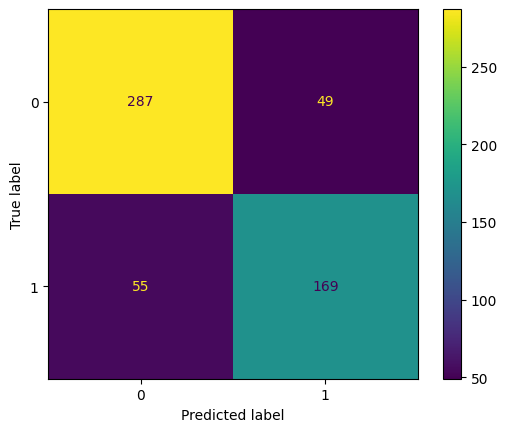

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf14, X_test, y_test)
plt.show()

RFC

In [ ]:
clf16.fit(X_train, y_train)

Pipeline(steps=[('randomForest',
                 RandomForestClassifier(max_features=14, n_estimators=200,
                                        random_state=42))])

In [ ]:
y_pred_16 = clf16.predict(X_test)
error_handler(lambda: get_clf_report(y_test, y_pred_16))

              precision    recall  f1-score   support

           0     0.8401    0.9226    0.8794       336
           1     0.8639    0.7366    0.7952       224

    accuracy                         0.8482       560
   macro avg     0.8520    0.8296    0.8373       560
weighted avg     0.8496    0.8482    0.8457       560

[0.554, 0.046]
[0.105, 0.295]


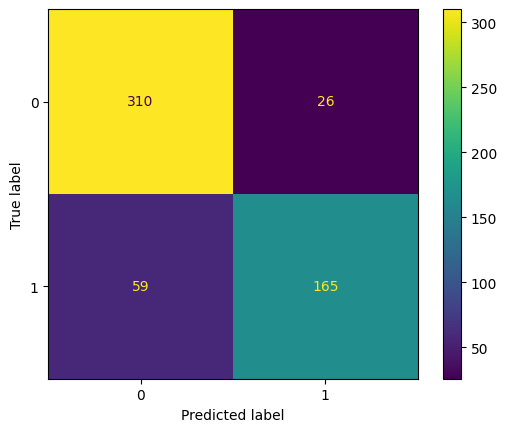

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf16, X_test, y_test)
plt.show()

AdaBoost

In [ ]:
clf19.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9, n_estimators=250,
                   random_state=42)

In [ ]:
y_pred_19 = clf19.predict(X_test)
error_handler(lambda: get_clf_report(y_test, y_pred_19))

              precision    recall  f1-score   support

           0     0.8687    0.8661    0.8674       336
           1     0.8000    0.8036    0.8018       224

    accuracy                         0.8411       560
   macro avg     0.8343    0.8348    0.8346       560
weighted avg     0.8412    0.8411    0.8411       560

[0.52, 0.08]
[0.079, 0.321]


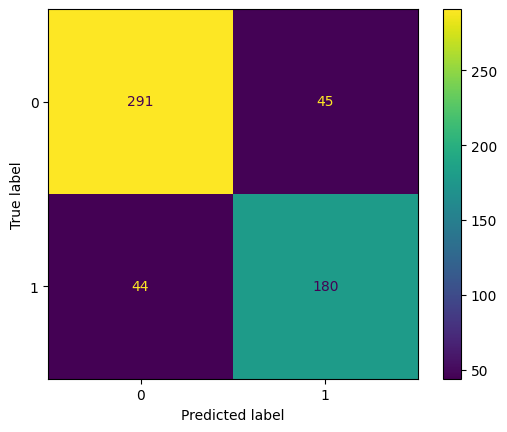

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf19, X_test, y_test)
plt.show()

GBC

In [ ]:
clf18.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=42)

In [ ]:
y_pred_18 = clf18.predict(X_test)
error_handler(lambda: get_clf_report(y_test, y_pred_18))

              precision    recall  f1-score   support

           0     0.8899    0.8899    0.8899       336
           1     0.8348    0.8348    0.8348       224

    accuracy                         0.8679       560
   macro avg     0.8624    0.8624    0.8624       560
weighted avg     0.8679    0.8679    0.8679       560

[0.534, 0.066]
[0.066, 0.334]


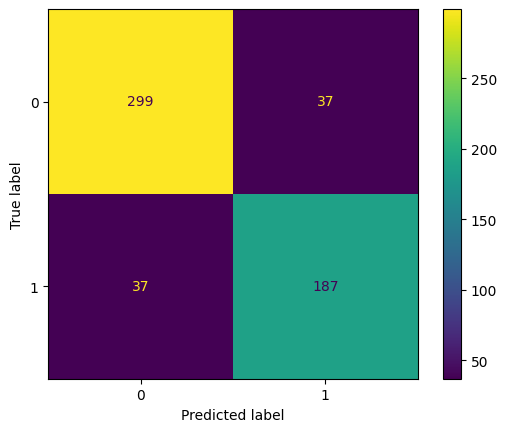

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf18, X_test, y_test)
plt.show()

SVC (rbf kernel) saját jellemzőkészletre (16)

In [ ]:
clf14.fit(X_train_top, y_train_top)

Pipeline(steps=[('scaler', RobustScaler(quantile_range=(0.25, 0.75))),
                ('transformer', PowerTransformer()),
                ('svc', SVC(C=10, random_state=42))])

In [ ]:
y_pred_14_top = clf14.predict(X_test_top)
error_handler(lambda: get_clf_report(y_test_top, y_pred_14_top))

              precision    recall  f1-score   support

           0     0.8519    0.8214    0.8364       336
           1     0.7458    0.7857    0.7652       224

    accuracy                         0.8071       560
   macro avg     0.7988    0.8036    0.8008       560
weighted avg     0.8094    0.8071    0.8079       560

[0.493, 0.107]
[0.086, 0.314]


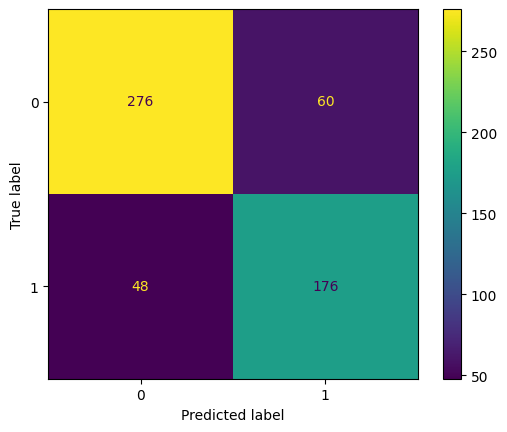

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf14, X_test_top, y_test_top)
plt.show()

RFC saját jellemzőkészletre (16)

In [ ]:
clf16.fit(X_train_top, y_train_top)

Pipeline(steps=[('randomForest',
                 RandomForestClassifier(max_features=14, n_estimators=200,
                                        random_state=42))])

In [ ]:
y_pred_16_top = clf16.predict(X_test_top)
error_handler(lambda: get_clf_report(y_test_top, y_pred_16_top))

              precision    recall  f1-score   support

           0     0.8647    0.8750    0.8698       336
           1     0.8091    0.7946    0.8018       224

    accuracy                         0.8429       560
   macro avg     0.8369    0.8348    0.8358       560
weighted avg     0.8425    0.8429    0.8426       560

[0.525, 0.075]
[0.082, 0.318]


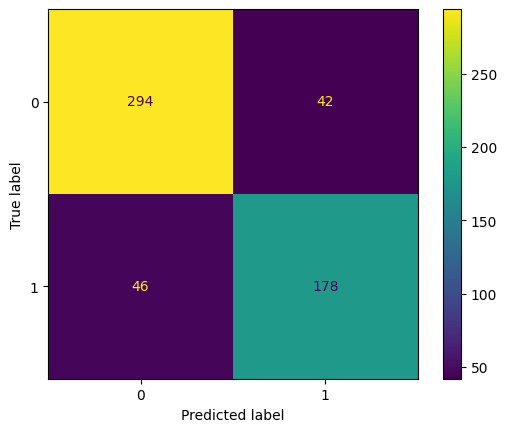

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf16, X_test_top, y_test_top)
plt.show()

AdaBoost saját jellemzőkészletre (16)

In [ ]:
clf19.fit(X_train_top, y_train_top)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9, n_estimators=250,
                   random_state=42)

In [ ]:
y_pred_19_top = clf19.predict(X_test_top)
error_handler(lambda: get_clf_report(y_test_top, y_pred_19_top))

              precision    recall  f1-score   support

           0     0.8661    0.8661    0.8661       336
           1     0.7991    0.7991    0.7991       224

    accuracy                         0.8393       560
   macro avg     0.8326    0.8326    0.8326       560
weighted avg     0.8393    0.8393    0.8393       560

[0.52, 0.08]
[0.08, 0.32]


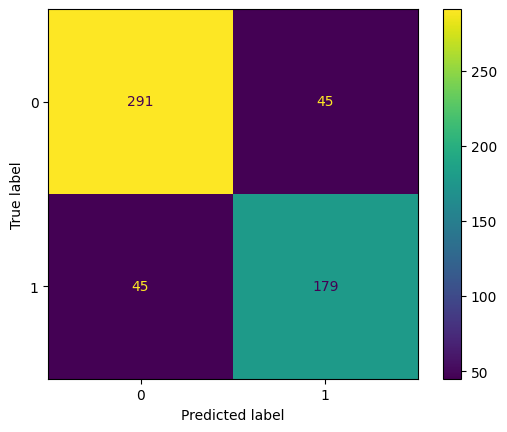

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf19, X_test_top, y_test_top)
plt.show()

GBC saját jellemzőkészletre (16)

In [ ]:
clf18.fit(X_train_top, y_train_top)

GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=42)

In [ ]:
y_pred_18_top = clf18.predict(X_test_top)
error_handler(lambda: get_clf_report(y_test_top, y_pred_18_top))

              precision    recall  f1-score   support

           0     0.8709    0.8631    0.8670       336
           1     0.7974    0.8080    0.8027       224

    accuracy                         0.8411       560
   macro avg     0.8341    0.8356    0.8348       560
weighted avg     0.8415    0.8411    0.8412       560

[0.518, 0.082]
[0.077, 0.323]


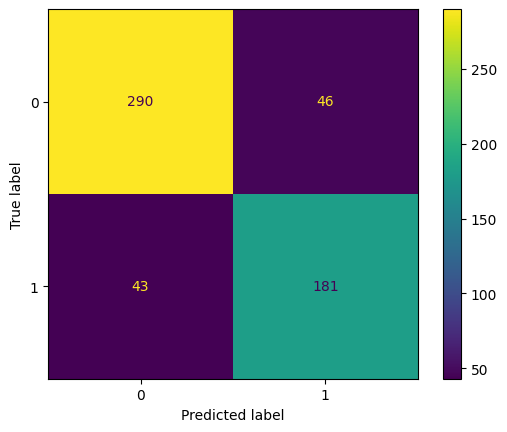

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf18, X_test_top, y_test_top)
plt.show()

VotingClassifier (legjobb 16 jellemzőre)

In [ ]:
clf20.fit(X_train_top, y_train_top)

VotingClassifier(estimators=[('ga',
                              Pipeline(steps=[('robustscaler',
                                               RobustScaler(quantile_range=(0.25,
                                                                            0.75))),
                                              ('powertransformer',
                                               PowerTransformer()),
                                              ('gaussiannb', GaussianNB())])),
                             ('knn',
                              Pipeline(steps=[('transformer',
                                               PowerTransformer()),
                                              ('clf',
                                               KNeighborsClassifier(n_neighbors=7))])),
                             ('svc_poly',
                              Pipeline(steps=[('scaler',
                                               RobustScaler(quantile_range=(0.25,
                                                                            0.75))),
                                              ('transformer',
                                               PowerTransformer()),
                                              ('svc',
                                               SVC(kernel='poly',
                                                   random_state=42))]))])

In [ ]:
y_pred_20 = clf20.predict(X_test_top)
error_handler(lambda: get_clf_report(y_test_top, y_pred_20))

              precision    recall  f1-score   support

           0     0.8206    0.8304    0.8254       336
           1     0.7409    0.7277    0.7342       224

    accuracy                         0.7893       560
   macro avg     0.7807    0.7790    0.7798       560
weighted avg     0.7887    0.7893    0.7890       560

[0.498, 0.102]
[0.109, 0.291]


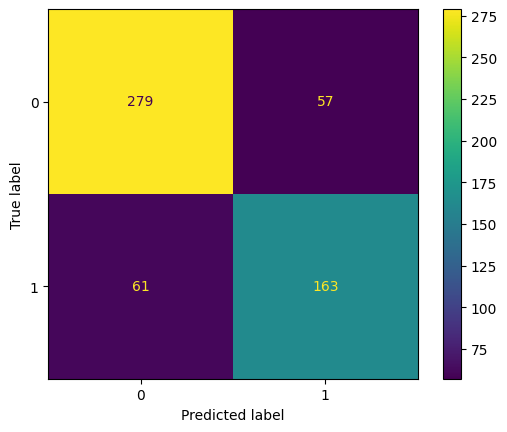

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf20, X_test_top, y_test_top)
plt.show()